# $NH_3$ gegevens RIVM MAN netwerk
# Introductie
Naar aanleiding van het artikel **"RIVM transparanter over eigen onderzoek"** in Nieuwe Oogst, kijken we in wat detail naar modellen gehanteerd door het RIVM. In dit artikel gaat het in het bijzonder over de rapportering over ammoniak ($NH_3$) concentraties. In het artikel wordt opgemerkt dat er slechts een beperkt aantal meetstations zijn, waarbij het meetstation in Vredepeel zich bovendien op slechts een steenworp afstand van een kippenstal bevindt. 

Naast dit netwerk (het landelijke luchtmeetnet http://www.luchtmeetnet.nl), is er ook een ander netwerk waar de $NH_3$ concentraties worden gemonitord in verschillende natuurgebieden. Dit is het zogenaamde MAN netwerk (Meetnet Ammoniak Nederland). We gebruiken de publiek beschikbare gegevens van dit netwerk om de aanpak van het RIVM te illustreren.

## Plan van aanpak
We laten eerst zien hoe we gegevens van meetpunten kunnen analyseren en combineren met andere data. In het tweede deel laten we zien hoe RIVM tot hun kaarten komt.

# Analyse van $NH_3$ meetpunten in natuurgebied De Groote Peel
## Inladen gegevens
De gegevens van het RIVM MAN netwerk kunnen online gedownload worden als een CSV file. De file bevat, voor zover aanwezig, van alle meetlocaties de jaargemiddelden. We beginnen met het inladen van alle gegevens. 

In [1]:
library(tidyverse)
library(ggmap)

dfNH3 <- read.table("./input/MAN_RIVM/Alle-Gebieden-jaar.csv",
                header = TRUE, sep = ";", dec = ",",
                stringsAsFactors=FALSE, quote="")
dfNH3 <- dfNH3[,-17]
dfNH3 <- dfNH3 %>% gather(X2005, X2006, X2007, X2008, X2009, 
                          X2010, X2011, X2012, X2013, 
                          X2014, X2015, X2016, X2017, 
                          key="jaar",value="conc") %>% 
                    na.omit() %>%
                    mutate(jaar=sub("X","",jaar)) 
dfNH3$jaar <- as.numeric(dfNH3$jaar)
head(dfNH3)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.
Please cite ggmap if you use it! See citation("ggmap") for details.


Gebied,Locatienummer,Locatienaam,jaar,conc
Bennekomse Meent,1,Midden,2005,12.5
Bennekomse Meent,2,Zuidwestrand,2005,14.2
Bennekomse Meent,3,Oostzijde,2005,14.6
Brabantse Wal,1,Groote Meer,2005,3.7
Brabantse Wal,2,Kriekelare Duinen,2005,2.1
Brabantse Wal,3,Klapwijk,2005,2.8


In deze dataset hebben we gegevens van alle locaties in het netwerk, voor vandaag beperken we ons tot natuurgebied "De Groote Peel".

In [2]:
dfNH3 <- dfNH3 %>% filter(Gebied == "Groote Peel")
head(dfNH3)

Gebied,Locatienummer,Locatienaam,jaar,conc
Groote Peel,1,Monument Asten,2005,10.2
Groote Peel,2,Eeuwselse Loop,2005,9.9
Groote Peel,3,Filose Peel,2005,11.1
Groote Peel,4,Zevende Baan,2005,10.9
Groote Peel,5,Gele Route,2005,9.7
Groote Peel,1,Monument Asten,2006,8.6


Het bestand bevat jaargemiddelden gemeten over 9 locaties in de Groote Peel. Allereerst nemen we per jaar het gemiddelde over alle locaties.

jaar,conc
2005,10.360000
2006,8.833333
2007,7.888889
2008,6.211111
2009,7.911111
2010,8.655556
2011,9.811111
2012,9.433333
2013,7.488889
2014,8.188889


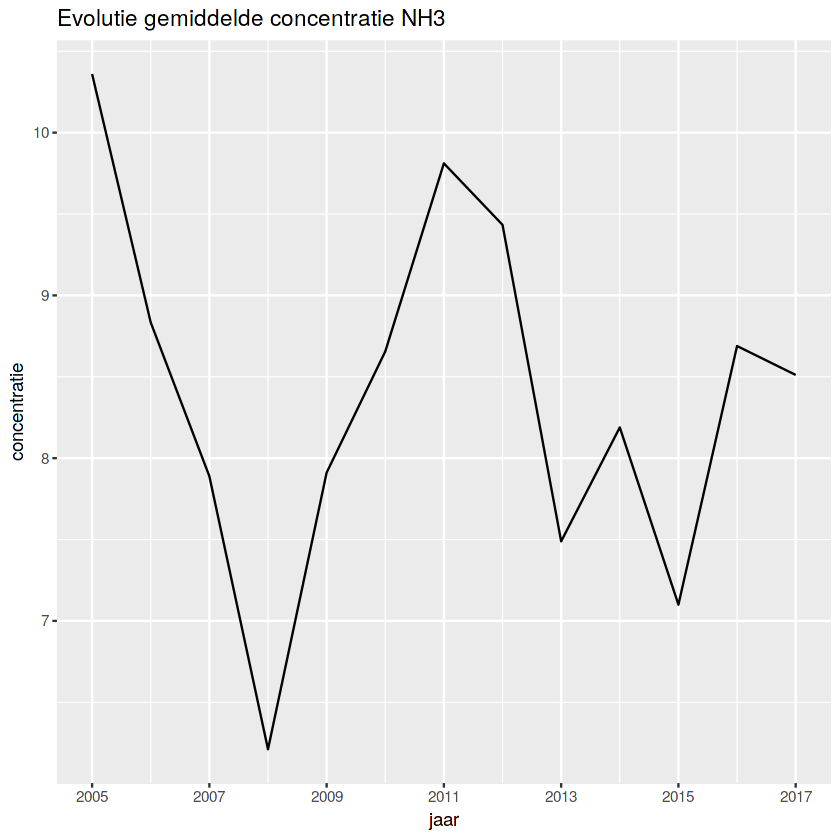

In [3]:
dfNH3_mean <- dfNH3 %>% group_by(jaar) %>% summarise(conc=mean(conc))
dfNH3_mean

ggplot(dfNH3_mean) + geom_line(aes(jaar,conc)) +
    labs(x = "jaar",y = "concentratie",
         title = "Evolutie gemiddelde concentratie NH3") +
    scale_x_continuous(breaks=seq(2005,2017,2))

We kunnen ook de afzonderlijke waarnemingen bekijken, merk op dat er op dit kleine gebied al veel variatie is.

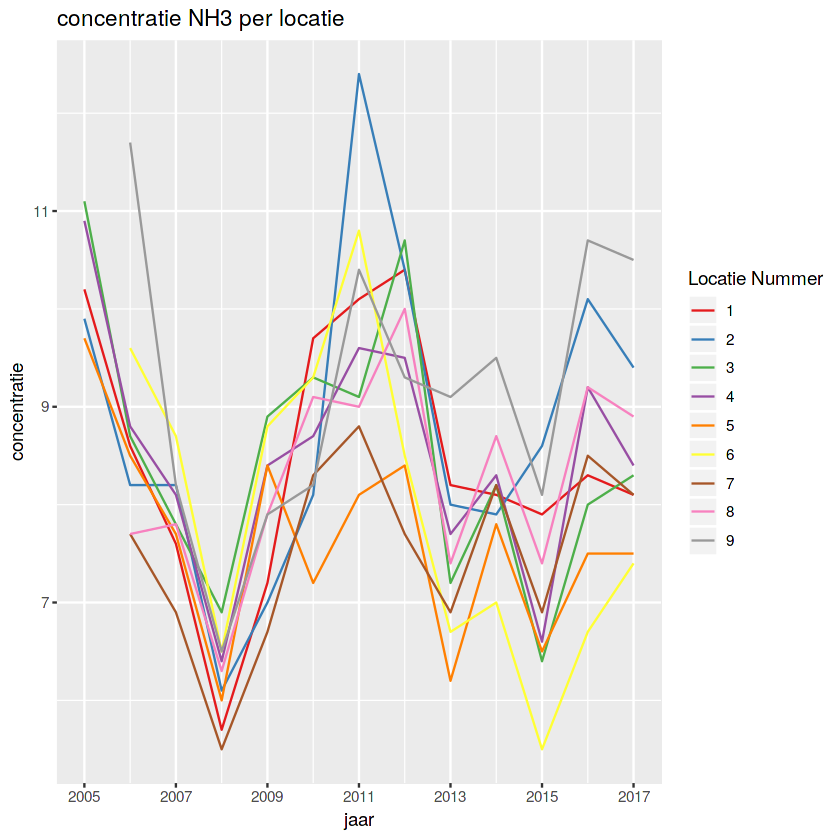

In [4]:
ggplot(dfNH3) + geom_line(aes(jaar,conc,color=as.factor(Locatienummer))) +
    labs(x="jaar",y="concentratie"
         ,title="concentratie NH3 per locatie") +
    scale_color_brewer(name="Locatie Nummer",palette = "Set1") +
    scale_x_continuous(breaks = seq(2005,2017,2))

## Combineren met KNMI data
We kunnen ons nu afvragen of de dip in 2008 misschien veroorzaakt wordt door weersgerelateerde factoren. We kunnen dit bekijken door te vergelijken met gegevens van het KNMI, deze kunnen op de website van het KNMI gedownload worden (http://projects.knmi.nl/klimatologie/daggegevens/selectie.cgi). De (historische) gegevens van het KNMI bevatten dagelijkse waarnemingen gemeten op een aantal weerstations. 

Het dichtstbijzijnde station bij de Peel is vliegbasis Volkel. We nemen dus de meetgegevens op vliegbasis Volkel en berekenen de jaargemiddelden.

In [5]:
dfknmi = read_csv("./input/MAN_RIVM/knmi.csv")
dfknmi <- dfknmi %>% filter(jaar>2004) %>% filter(jaar<2018)
dfknmi <- dfknmi %>% filter(station=="Volkel")
dfknmi

Parsed with column specification:
cols(
  station = col_character(),
  jaar = col_double(),
  temperatuur = col_double(),
  zonneschijn = col_double(),
  luchtdruk = col_double(),
  neerslag = col_double(),
  luchtvochtigheid = col_double()
)


station,jaar,temperatuur,zonneschijn,luchtdruk,neerslag,luchtvochtigheid
Volkel,2005,10.578630,3.906849,1.017098,20.80000,0.8217260
Volkel,2006,11.070137,3.603836,1.016139,19.21644,0.8012055
Volkel,2007,11.034247,3.515342,1.016218,23.20274,0.8258904
Volkel,2008,10.190710,3.635519,1.014853,19.15847,0.8207923
Volkel,2009,10.336986,3.767123,1.014284,18.83836,0.8134795
Volkel,2010,9.073425,3.463288,1.013746,21.07945,0.8028767
Volkel,2011,10.850411,4.034247,1.016826,21.25479,0.8023836
Volkel,2012,10.217486,3.607923,1.015608,23.06557,0.8133880
Volkel,2013,9.850685,3.402740,1.015478,18.83014,0.7977534
Volkel,2014,11.553425,3.878356,1.013756,21.09315,0.8126301


We voegen deze samen met de eerder berekende $NH_{3}$ gemiddelden.

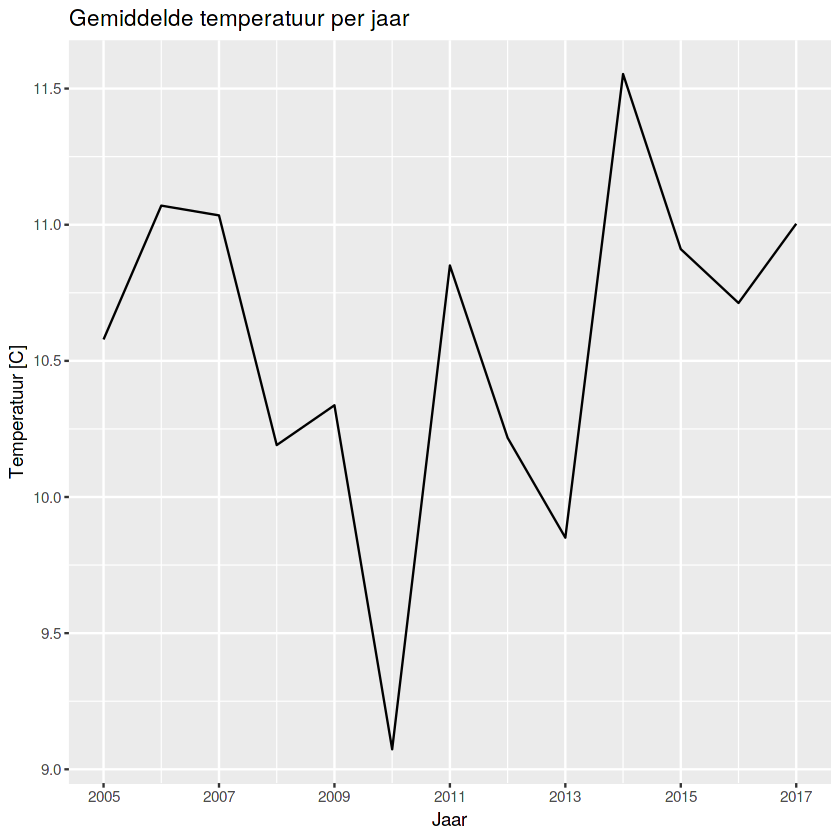

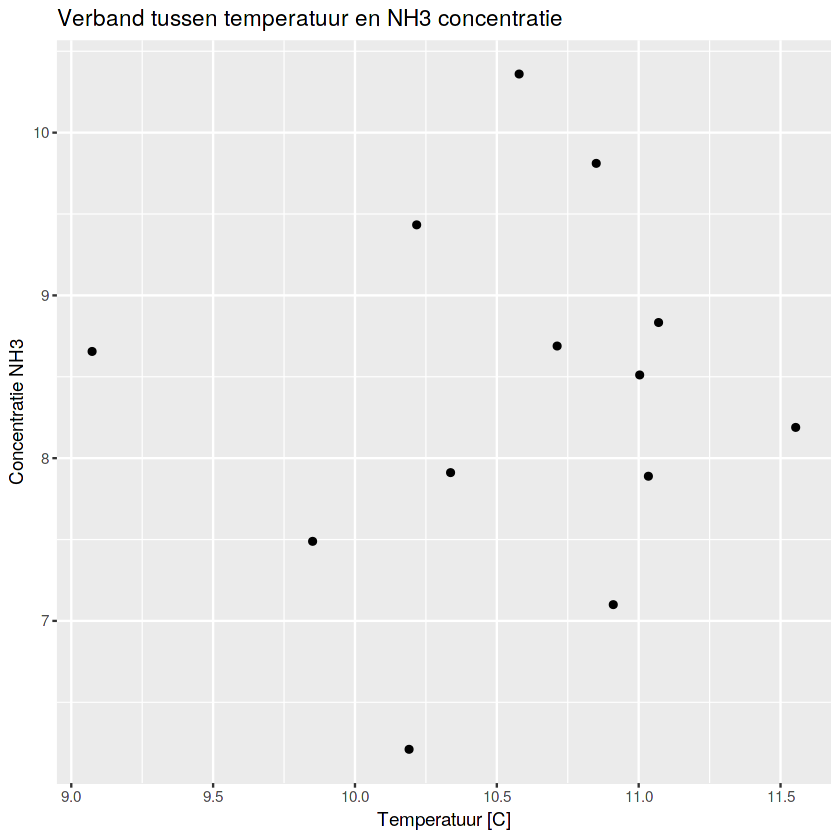

In [6]:
dfNH3_mean <- merge(dfNH3_mean,dfknmi,by ="jaar")

ggplot(dfNH3_mean) + geom_line(aes(jaar,temperatuur)) +
        labs(x="Jaar",y="Temperatuur [C]",
             title="Gemiddelde temperatuur per jaar") +
        scale_x_continuous(breaks=seq(2005,2017,2))
ggplot(dfNH3_mean) + geom_point(aes(temperatuur,conc)) +
        labs(x="Temperatuur [C]",y="Concentratie NH3",
             title="Verband tussen temperatuur en NH3 concentratie")

## Formele statistische analyse

Er lijkt geen verband tussen temperatuur en $NH_3$ concentratie. We verifiëren dit aan de hand van correlaties. Ook beschouwen we de andere mogelijke variabelen in de knmi data.

In [7]:
cor.mat <- cor(dfNH3_mean[,c(2,4:8)])
print(round(cor.mat,2))

                 conc temperatuur zonneschijn luchtdruk neerslag
conc             1.00        0.08        0.29      0.27     0.40
temperatuur      0.08        1.00        0.54      0.39     0.22
zonneschijn      0.29        0.54        1.00      0.43     0.14
luchtdruk        0.27        0.39        0.43      1.00     0.24
neerslag         0.40        0.22        0.14      0.24     1.00
luchtvochtigheid 0.06        0.06       -0.09     -0.24     0.24
                 luchtvochtigheid
conc                         0.06
temperatuur                  0.06
zonneschijn                 -0.09
luchtdruk                   -0.24
neerslag                     0.24
luchtvochtigheid             1.00


We zien, hoewel zwak, een mogelijke relatie tussen uren zonneschijn, luchtdruk, neerslag en de concentratie.

In [8]:
mdl <- lm(conc~temperatuur+zonneschijn+luchtdruk+neerslag+luchtvochtigheid,
          data=dfNH3_mean)
summary(mdl)


Call:
lm(formula = conc ~ temperatuur + zonneschijn + luchtdruk + neerslag + 
    luchtvochtigheid, data = dfNH3_mean)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6756 -0.4812  0.1062  0.4759  1.4520 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)
(Intercept)      -140.4815   364.1344  -0.386    0.711
temperatuur        -0.3849     0.7054  -0.546    0.602
zonneschijn         1.5445     2.1214   0.728    0.490
luchtdruk         134.9416   353.0458   0.382    0.714
neerslag            0.2731     0.2670   1.023    0.340
luchtvochtigheid    5.4725    37.6353   0.145    0.888

Residual standard error: 1.266 on 7 degrees of freedom
Multiple R-squared:  0.2574,	Adjusted R-squared:  -0.273 
F-statistic: 0.4854 on 5 and 7 DF,  p-value: 0.7783


Het minst significante verband is er tussen luchtdruk en luchtvochtigheid; we elimineren dit verband.

In [9]:
mdl <- update(mdl,.~.-luchtvochtigheid)
summary(mdl)


Call:
lm(formula = conc ~ temperatuur + zonneschijn + luchtdruk + neerslag, 
    data = dfNH3_mean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.73513 -0.48868  0.09896  0.47920  1.55068 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) -120.4195   315.6954  -0.381    0.713
temperatuur   -0.3702     0.6540  -0.566    0.587
zonneschijn    1.5251     1.9834   0.769    0.464
luchtdruk    119.2298   314.8711   0.379    0.715
neerslag       0.2845     0.2391   1.190    0.268

Residual standard error: 1.186 on 8 degrees of freedom
Multiple R-squared:  0.2552,	Adjusted R-squared:  -0.1172 
F-statistic: 0.6853 on 4 and 8 DF,  p-value: 0.6219


Om dezelfde reden elimineren we nu luchtdruk als verklarende variabele. Enzovoort...

In [10]:
mdl <- update(mdl,.~.-luchtdruk)
summary(mdl)


Call:
lm(formula = conc ~ temperatuur + zonneschijn + neerslag, data = dfNH3_mean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.63357 -0.50866  0.03733  0.47230  1.67634 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  -0.9116     7.1654  -0.127    0.902
temperatuur  -0.3272     0.6127  -0.534    0.606
zonneschijn   1.7432     1.8054   0.966    0.359
neerslag      0.3003     0.2239   1.341    0.213

Residual standard error: 1.128 on 9 degrees of freedom
Multiple R-squared:  0.2418,	Adjusted R-squared:  -0.01087 
F-statistic: 0.957 on 3 and 9 DF,  p-value: 0.4538


In [11]:
mdl <- update(mdl,.~.-1)
summary(mdl)


Call:
lm(formula = conc ~ temperatuur + zonneschijn + neerslag - 1, 
    data = dfNH3_mean)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6764 -0.4622 -0.0418  0.4798  1.6925 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
temperatuur  -0.3503     0.5554  -0.631    0.542
zonneschijn   1.6400     1.5317   1.071    0.309
neerslag      0.2868     0.1875   1.530    0.157

Residual standard error: 1.071 on 10 degrees of freedom
Multiple R-squared:  0.9877,	Adjusted R-squared:  0.984 
F-statistic:   267 on 3 and 10 DF,  p-value: 7.676e-10


In [12]:
mdl <- update(mdl,.~.-temperatuur)
summary(mdl)


Call:
lm(formula = conc ~ zonneschijn + neerslag - 1, data = dfNH3_mean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.69126 -0.40037 -0.03118  0.60689  1.81645 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
zonneschijn   0.8940     0.9462   0.945    0.365
neerslag      0.2428     0.1692   1.435    0.179

Residual standard error: 1.041 on 11 degrees of freedom
Multiple R-squared:  0.9872,	Adjusted R-squared:  0.9848 
F-statistic: 423.5 on 2 and 11 DF,  p-value: 3.922e-11


In [13]:
mdl <- update(mdl,.~.-zonneschijn+1)
summary(mdl)


Call:
lm(formula = conc ~ neerslag, data = dfNH3_mean)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6683 -0.2907 -0.1011  0.3658  1.9814 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   2.0536     4.3365   0.474    0.645
neerslag      0.3041     0.2076   1.465    0.171

Residual standard error: 1.072 on 11 degrees of freedom
Multiple R-squared:  0.1632,	Adjusted R-squared:  0.08716 
F-statistic: 2.146 on 1 and 11 DF,  p-value: 0.171


Er lijkt ook geen verband met neerslag. **De jaargemiddelden over de KNMI data zijn niet in staat de schommelingen in $NH_3$ te verklaren.**

## Hoe maakt RIVM kaarten?
Zoals in het begin gememoreerd, publiceert RIVM gedetailleerde kaarten van Nederland voor $NH_3$ concentraties (maar ook voor fijnstof, $CO_{2}$ en dergelijke). Deze kaarten zijn, zoals in het krantenartikel gememoreerd, gebaseerd op slechts een beperkt aantal waarnemingen. We gaan in dit tweede deel laten zien hoe deze kaarten tot stand komen.

### Geografische gegevens
Om de vraag te beantwoorden hebben we geografische gegevens nodig, in het bijzonder de exacte locaties van de meetstations. Helaas zijn deze niet gegeven in de dataset, met behulp van Google maps en een kaartje op de site van het RIVM hebben we de locaties zo goed mogelijk bepaald. Voor onze demonstratie-doeleinden is dit voldoende, in de praktijk zouden we een wandelingetje met een GPS in de Groote Peel moeten maken.

We beginnen met het zichtbaar maken van de gegevens op een kaart. In elke grafiek zien we voor het bijbehorende jaar de gemiddelde $NH_3$ concentraties op de meetpunten. Merk opnieuw op dat er op dit kleine gebied reeds veel variatie is.

Parsed with column specification:
cols(
  Nummer = col_double(),
  Naam = col_character(),
  Longitude = col_double(),
  Latitude = col_double()
)
Source : http://tile.stamen.com/terrain/12/2113/1364.png
Source : http://tile.stamen.com/terrain/12/2114/1364.png
Source : http://tile.stamen.com/terrain/12/2113/1365.png
Source : http://tile.stamen.com/terrain/12/2114/1365.png


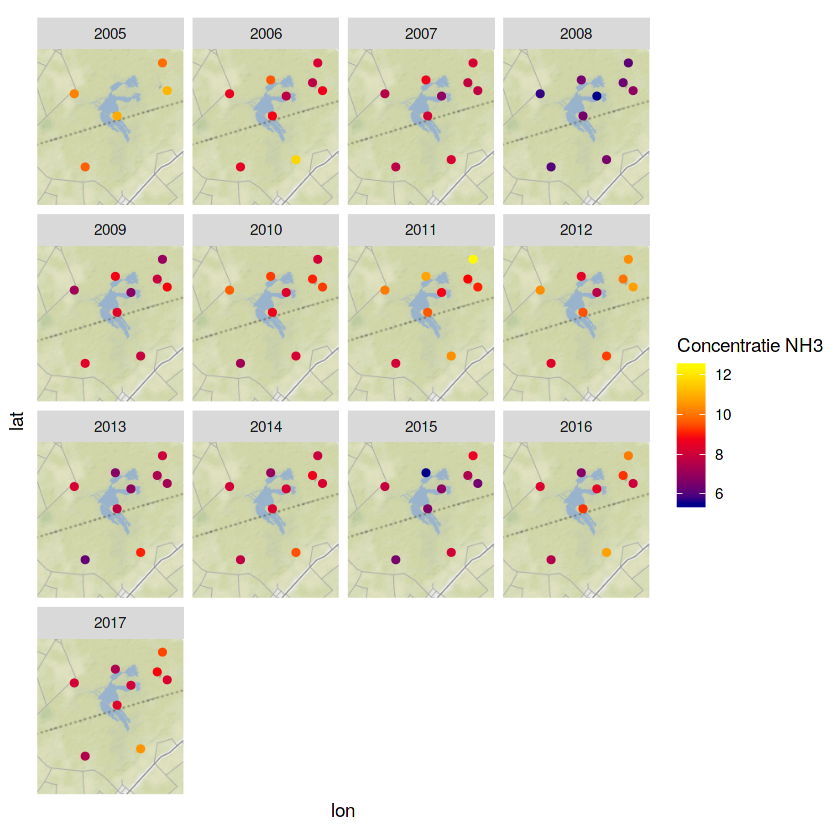

In [14]:
dfpeel <- read_csv("./input/MAN_RIVM/locations.csv")
dfloc <- merge(dfNH3,dfpeel,by.x="Locatienummer",by.y="Nummer")
dfloc <- dfloc %>% select(Locatienummer,jaar,conc,Longitude,Latitude)
dfloc <- as.data.frame(dfloc)


peel.box <- c(left=5.78,right=5.84,top=51.36,bottom=51.32)
peel.map <- get_stamenmap(peel.box,zoom=12,maptype="terrain")
ggmap(peel.map) +
    geom_point(aes(x=Longitude,y=Latitude,color=conc),data=dfloc) +
    scale_color_gradient2(guide="colorbar",name="Concentratie NH3",
                         low="darkblue",mid="red",
                          high="yellow",midpoint=9) +
    facet_wrap(~jaar,ncol=4) +
    theme(axis.ticks = element_blank(),axis.text = element_blank())

Voor analyse van geografische data wordt veel gebruik gemaakt van GIS systemen (GIS staat voor *Geographical Information System*). Een populair GIS programma is ArcGis, er zijn veel geografische datasets te downloaden in het ArcGis formaat in zogenaamde Shapefiles. Wellicht is er zo'n publieke file voor de Groote Peel, in dit geval heb ik er zelf een gemaakt op basis opnieuw van Google Maps.

Loading required package: sp

Attaching package: ‘raster’

The following object is masked from ‘package:dplyr’:

    select

The following object is masked from ‘package:tidyr’:

    extract



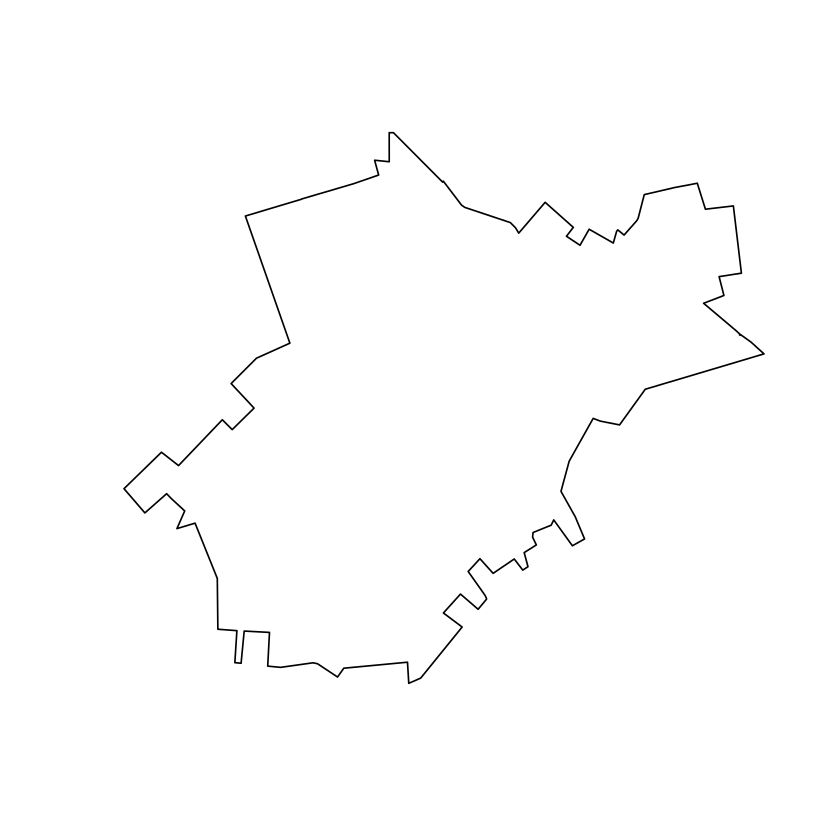

In [15]:
library(raster)
grootepeel <- shapefile("./input/MAN_RIVM/grootepeel.shp")
plot(grootepeel)

### Interpolatie
Onder interpolatie verstaan we wiskundige methoden om gegeven waarnemingen in een aantal punten de waarden in de tussenliggende punten te berekenen. We gaan hieronder zien hoe RIVM dit interpolatie-proces uitvoert.

De eenvoudigste methode hiervoor is *Nearest Neighbors*: we zetten de waarde voor een gegeven nieuw punt gelijk aan de waarde in het dichtsbijzijnde punt. We kunnen het vlak waarin de meetpunten zich bevinden onderverdelen in gebieden die het dichtst bij een gegeven meetpunt liggen. Dit ziet er als volgt uit.


Attaching package: ‘dismo’

The following object is masked from ‘package:ggmap’:

    geocode

Loading required namespace: deldir


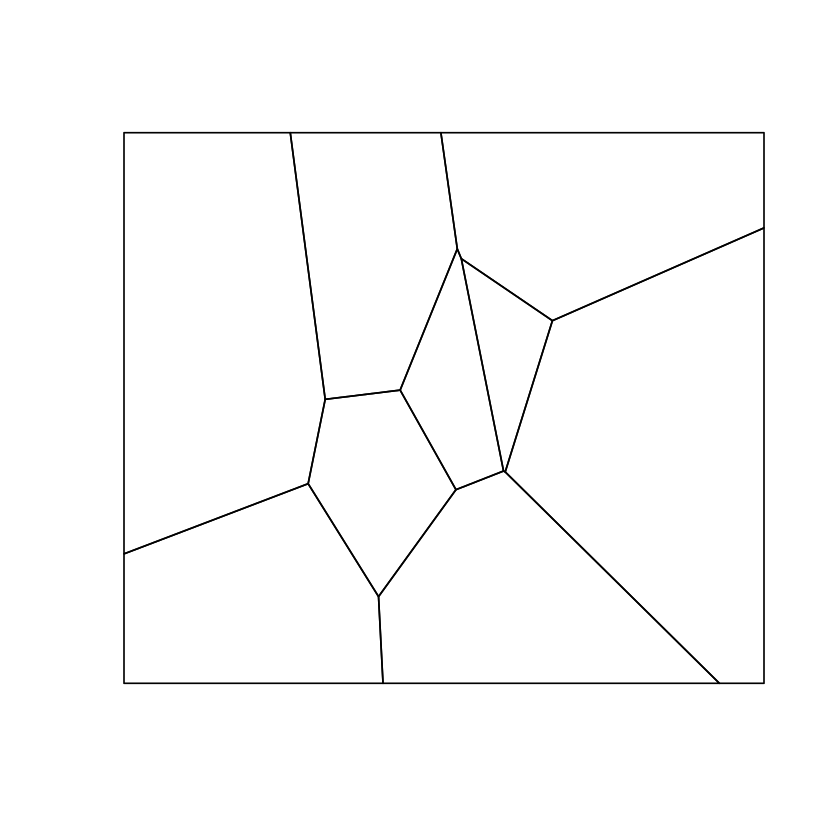

In [16]:
bbpeel <- bbox(grootepeel)
dsp <- SpatialPoints(dfpeel[,3:4],
        proj4string = 
        CRS("+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"),
        bbox = bbpeel)
d <- dfloc %>% group_by(Locatienummer) %>% 
               summarise(Longitude=first(Longitude),
                         Latitude=first(Latitude),
                         conc = mean(conc))
d <- as.data.frame(d)
dsp <- SpatialPointsDataFrame(dsp,d)

library(dismo)
v <- voronoi(dsp,ext=extent(grootepeel))
plot(v)

Als we dan de $NH_3$ concentratie weergeven door middel van het inkleuren van de gebieden, krijgen we het volgende plaatje.

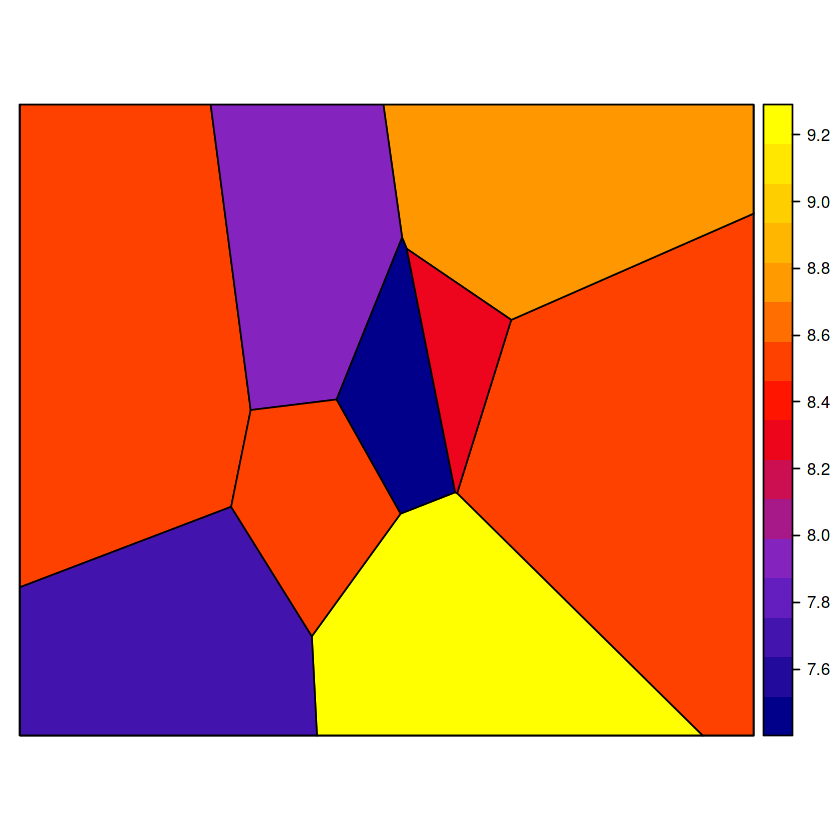

In [17]:
spplot(v,"conc", col.regions = 
           colorRampPalette(c("darkblue", "purple3",
                              "red","orange","yellow"))(500))

Dit ziet er wat raar uit, maar als we dit doorsnijden met onze eerdere kaart voor de Groote Peel, krijgen we het volgende beeld.

Loading required namespace: rgeos


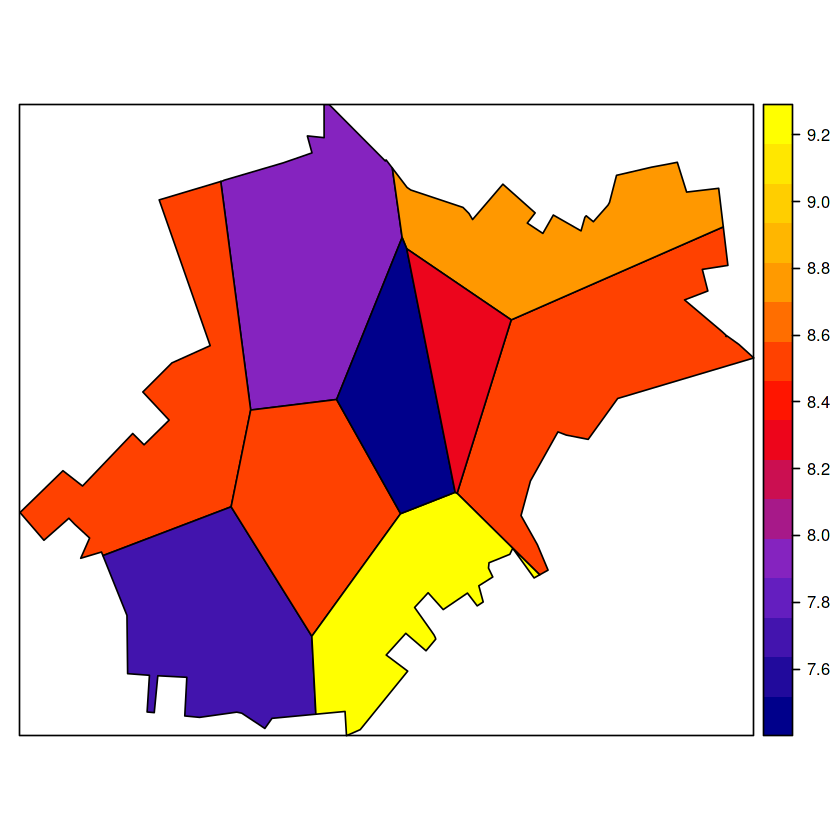

In [18]:
vgpeel <- intersect(v,grootepeel)
spplot(vgpeel,"conc", col.regions =
       colorRampPalette(c("darkblue", "purple3","red",
                          "orange","yellow"))(500))

De kaart hierboven is opgebouwd uit ingekleurde veelhoeken. Echter, voor de meer geavanceerde methoden die we hieronder even aanstippen, is het gemakkelijker om met rasters van punten te werken. We bepalen daarom een raster van 500x500 punten in het Groote Peel gebied. De kaart ziet er dan als volgt uit.

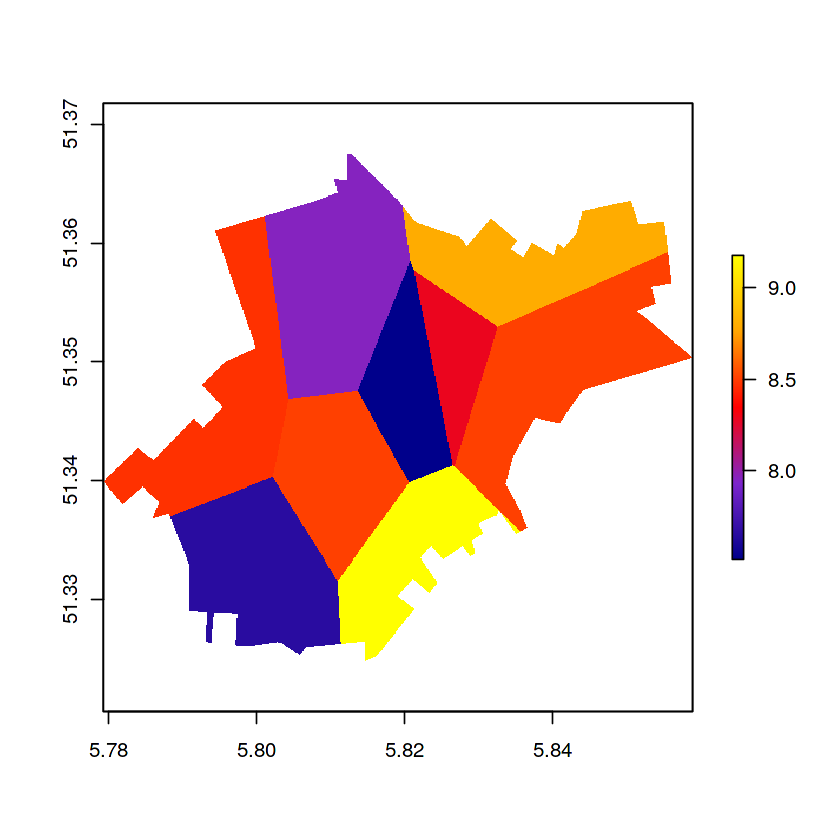

In [19]:
r <- raster(grootepeel,ncols=500,nrows=500)
vr <- rasterize(vgpeel,r,"conc")
plot(vr, col = 
     colorRampPalette(c("darkblue", "purple3","red",
                        "orange","yellow"))(500))

## Meer geavanceerde interpolatie

Het RIVM maakt gebruik van een meer geavanceerde methode. Deze interpolatie-methode levert de volgende kaart op.

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 


[inverse distance weighted interpolation]


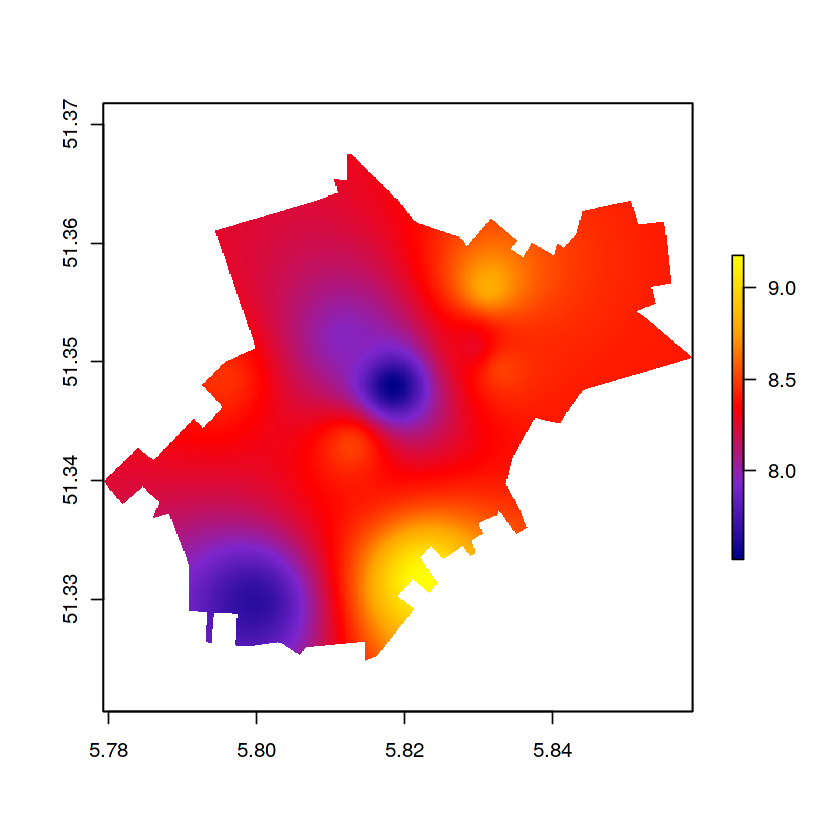

In [20]:
library(gstat)
gs <- gstat(formula=conc~1,locations=dsp)
nn <- interpolate(r,gs)
nnmsk <- mask(nn,grootepeel)
plot(nnmsk, col = 
     colorRampPalette(c("darkblue","purple3",
                        "red","orange","yellow"))(500))

We vergelijken dit met een andere interpolatie techniek.

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-2 (2019-03-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps

Attaching package: ‘maps’

The following object is masked from ‘package:purrr’:

    map

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 


Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.0002702402 (eff. df= 8.550003 )


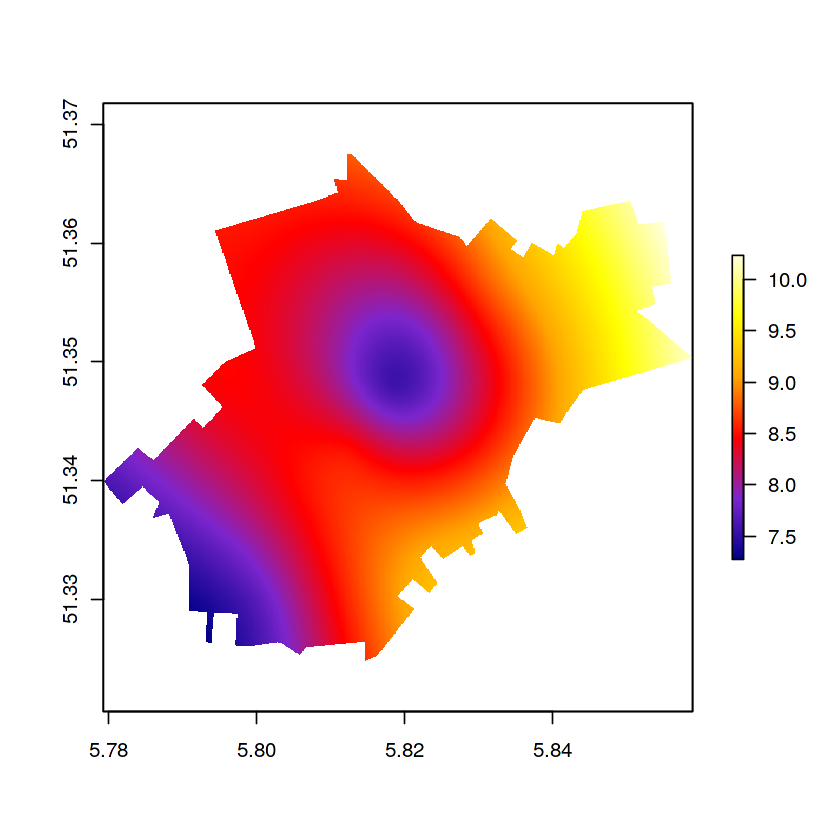

In [21]:
library(fields)
m <- Tps(coordinates(dsp),dsp$conc)
tps <- interpolate(r,m)
tps <- mask(tps,grootepeel)
plot(tps, col = 
     colorRampPalette(c("darkblue","purple3","red",
                        "orange","yellow","lightyellow"))(500))

Merk op dat verschillende methoden tot een ander beeld leiden, terwijl de waarden in de meetpunten op elke grafiek dezelfde is! 

## Conclusie
In dit notebook hebben we gekeken naar de manier waarop RIVM kaarten maakt voor de $NH_3$ concentraties. We zien dat we voorzichtig moeten zijn met de interpretatie van de kaarten in het geval van weinig datapunten.